## Super resolution

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
import os 
from os import listdir
from os.path import isfile, join
import shutil


In [3]:
# styled_files = [styled_file.split('style_')[1] for styled_file in os.listdir(output_dir)]
# unprocessed_content = [content_img for content_img in os.listdir(content_img_dir) if content_img not in styled_files]

# for content_img in [content_img for content_img in unprocessed_content if ".jpg" in content_img or "png" in content_img]:
#     print(content_img)  
#     out_img = style_transfer(content_img)
#     out_img.save(output_dir + 'style_' + content_img)

In [4]:
styled_src = Path('../../TampaAI/N_A_A_Style/output/pets_monet_sunset')
full_size_img_src_dir = '/home/ml1/.fastai/data/oxford-iiit-pet/images/'
img_dir = Path('images')
full_size_dir = img_dir/'orig'
styled_dir = img_dir/'styled'
small_96_dir = img_dir/'small-96'
small_256_dir = img_dir/'small-256'

In [5]:

styled_files = [f for f in listdir(styled_src) if isfile(join(styled_src, f))]
root_of_styled_files = [styled_file.split('style_')[1] for styled_file in styled_files]
root_of_styled_files

['great_pyrenees_177.jpg',
 'newfoundland_181.jpg',
 'Bombay_37.jpg',
 'staffordshire_bull_terrier_137.jpg',
 'japanese_chin_36.jpg',
 'Persian_138.jpg',
 'Ragdoll_90.jpg',
 'scottish_terrier_198.jpg',
 'boxer_197.jpg',
 'Birman_183.jpg',
 'Siamese_30.jpg',
 'keeshond_65.jpg',
 'staffordshire_bull_terrier_73.jpg',
 'Maine_Coon_108.jpg',
 'staffordshire_bull_terrier_107.jpg',
 'english_cocker_spaniel_117.jpg',
 'pug_170.jpg',
 'Siamese_122.jpg',
 'miniature_pinscher_4.jpg',
 'Siamese_151.jpg',
 'german_shorthaired_185.jpg',
 'american_pit_bull_terrier_181.jpg',
 'great_pyrenees_107.jpg',
 'great_pyrenees_140.jpg',
 'japanese_chin_167.jpg',
 'pug_58.jpg',
 'havanese_167.jpg',
 'Siamese_191.jpg',
 'Maine_Coon_244.jpg',
 'Sphynx_25.jpg',
 'Siamese_227.jpg',
 'Bengal_93.jpg',
 'wheaten_terrier_5.jpg',
 'havanese_160.jpg',
 'Sphynx_197.jpg',
 'english_cocker_spaniel_84.jpg',
 'boxer_106.jpg',
 'miniature_pinscher_77.jpg',
 'english_setter_146.jpg',
 'Maine_Coon_217.jpg',
 'yorkshire_terrier_

In [6]:
content_img_dir = '/home/ml1/.fastai/data/oxford-iiit-pet/images/'
# processed_content = [content_img for content_img in os.listdir(content_img_dir) if content_img in root_of_styled_files]
# processed_content

In [7]:
for file_name in root_of_styled_files:
    full_file_name = os.path.join(full_size_img_src_dir, file_name)
    shutil.copy(full_file_name, full_size_dir)

In [8]:
for file_name in root_of_styled_files:
    full_file_name = os.path.join(styled_src, 'style_'+file_name)
    shutil.copy(full_file_name, styled_dir)
    style_file_name = 'style_' + file_name
    shutil.move(styled_dir/style_file_name, styled_dir/file_name ) 

In [9]:
# from pathlib import Path
# import glob
# # path = untar_data(URLs.PETS)
# styled_src = Path('../..')
# for file_name in glob.glob(styled_src):
#     print(file_name)


In [10]:
# path_hr = path/'images'
# path_lr = path/'small-96'
# path_mr = path/'small-256'
path_hr = styled_dir
path_lr = small_96_dir
path_mr = small_256_dir

In [11]:
il = ImageItemList.from_folder(full_size_dir)

In [12]:
# f_list = il.to_df().head()

In [13]:
def resize_one(fn,i):
#     dest = path_lr/fn.relative_to(path_hr)
    dest = path_lr/fn.relative_to(full_size_dir)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [14]:
# to create smaller images, uncomment the next line when you run this the first time
# parallel(resize_one, il.items)

In [15]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [16]:
src

ItemLists;

Train: ImageImageList (2753 items)
[Image (3, 96, 128), Image (3, 96, 128), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 128)]...
Path: images/small-96;

Valid: ImageImageList (305 items)
[Image (3, 175, 96), Image (3, 96, 107), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 144)]...
Path: images/small-96;

Test: None

In [17]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [18]:
data = get_data(bs,size)

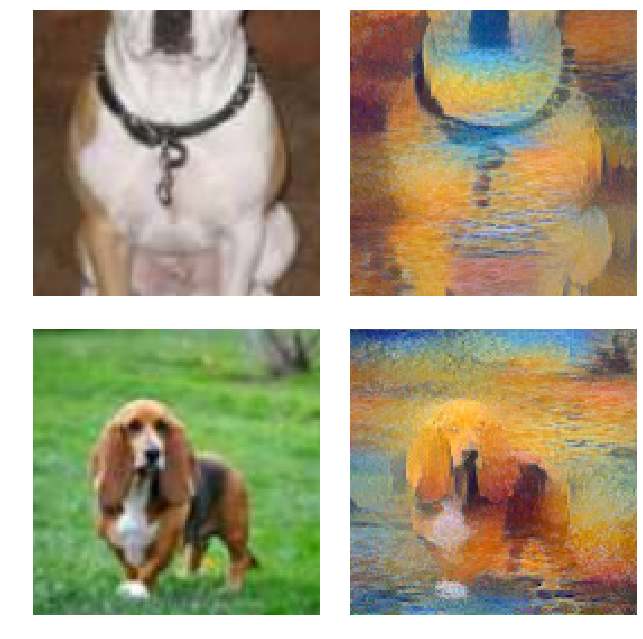

In [19]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [20]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [21]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [22]:
gram_matrix(t)

tensor([[[0.1315, 0.1074, 0.0764],
         [0.1074, 0.0923, 0.0687],
         [0.0764, 0.0687, 0.0562]],

        [[0.1315, 0.1074, 0.0764],
         [0.1074, 0.0923, 0.0687],
         [0.0764, 0.0687, 0.0562]]])

In [23]:
base_loss = F.l1_loss

In [24]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [25]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [26]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [27]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [28]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();
learn.data.batch_size

32

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


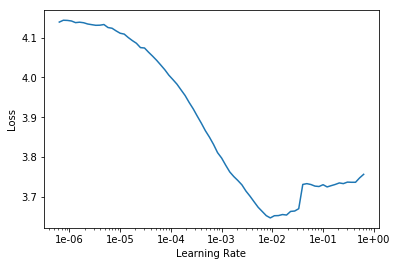

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
lr = 1e-3

In [31]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.888878,2.802722,0.400150,0.311663,0.346429,0.139423,0.516962,0.871203,0.216891
2,2.760338,2.711827,0.380862,0.307217,0.342594,0.137599,0.483044,0.845922,0.214589
3,2.710657,2.681858,0.385092,0.307107,0.336578,0.135424,0.471399,0.835094,0.211165
4,2.684432,2.710310,0.432943,0.308145,0.332644,0.134307,0.467406,0.825642,0.209224
5,2.672602,2.658380,0.393814,0.303303,0.332759,0.132464,0.472350,0.814572,0.209118
6,2.645839,2.582036,0.370325,0.300303,0.327458,0.131722,0.448097,0.796905,0.207227
7,2.623099,2.554564,0.368303,0.299261,0.327110,0.131516,0.430205,0.790090,0.208079
8,2.611051,2.564203,0.379349,0.300568,0.326092,0.130733,0.432082,0.788396,0.206983
9,2.586885,2.528744,0.371698,0.299624,0.323526,0.130359,0.421029,0.777894,0.204614
10,2.542103,2.467600,0.349594,0.297600,0.321580,0.128988,0.405693,0.759712,0.204433


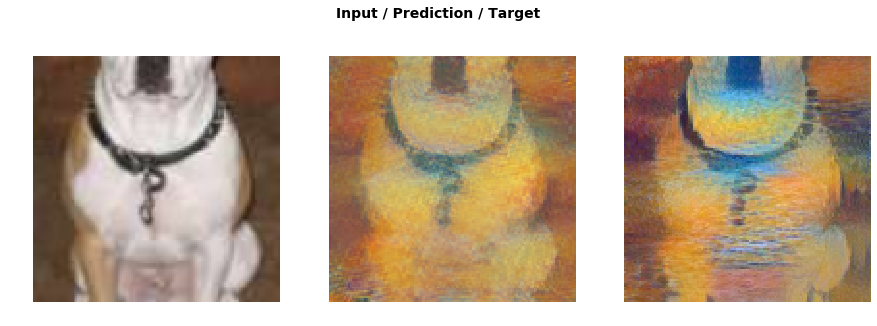

In [32]:
do_fit('1a', slice(lr*10))

In [33]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.508552,2.470243,0.348827,0.298201,0.321827,0.129125,0.405801,0.761989,0.204473
2,2.502695,2.466722,0.347024,0.297699,0.321056,0.129063,0.406118,0.761333,0.204430
3,2.494808,2.463147,0.347236,0.297211,0.321384,0.129191,0.405461,0.758363,0.204299
4,2.498787,2.449929,0.345081,0.297055,0.320709,0.128554,0.400691,0.754388,0.203450
5,2.492712,2.469727,0.345163,0.296634,0.320326,0.128987,0.409961,0.763855,0.204802
6,2.487676,2.465504,0.346660,0.296866,0.320187,0.129350,0.406975,0.760758,0.204709
7,2.476392,2.437048,0.343815,0.295747,0.318131,0.127907,0.397501,0.751330,0.202617
8,2.477364,2.429764,0.342185,0.296188,0.318579,0.128037,0.394582,0.747574,0.202619
9,2.476491,2.434588,0.340103,0.295186,0.318055,0.127891,0.399896,0.750511,0.202946
10,2.466644,2.422903,0.338207,0.295324,0.317424,0.127604,0.394378,0.747054,0.202912


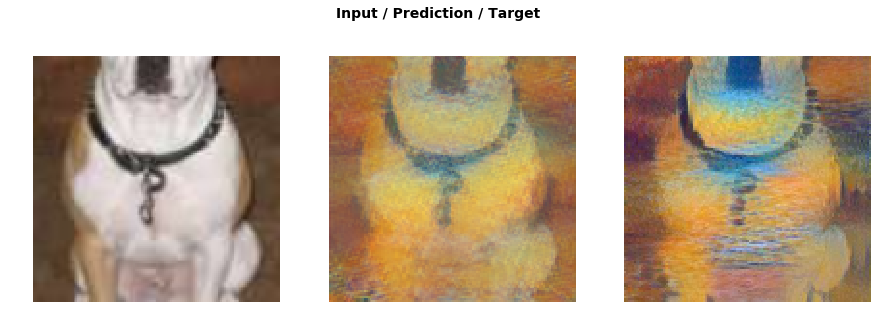

In [34]:
do_fit('1b', slice(1e-5,lr))

In [35]:
data = get_data(12,size*2)
data

ImageDataBunch;

Train: LabelList
y: ImageItemList (2753 items)
[Image (3, 256, 342), Image (3, 256, 341), Image (3, 256, 335), Image (3, 256, 341), Image (3, 256, 341)]...
Path: images/small-96
x: ImageImageList (2753 items)
[Image (3, 96, 128), Image (3, 96, 128), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 128)]...
Path: images/small-96;

Valid: LabelList
y: ImageItemList (305 items)
[Image (3, 468, 256), Image (3, 256, 287), Image (3, 256, 335), Image (3, 256, 341), Image (3, 256, 384)]...
Path: images/small-96
x: ImageImageList (305 items)
[Image (3, 175, 96), Image (3, 96, 107), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 144)]...
Path: images/small-96;

Test: None

In [36]:
learn.data = data
learn.freeze()
gc.collect()

19688

In [37]:
learn

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (2753 items)
[Image (3, 256, 342), Image (3, 256, 341), Image (3, 256, 335), Image (3, 256, 341), Image (3, 256, 341)]...
Path: images/small-96
x: ImageImageList (2753 items)
[Image (3, 96, 128), Image (3, 96, 128), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 128)]...
Path: images/small-96;

Valid: LabelList
y: ImageItemList (305 items)
[Image (3, 468, 256), Image (3, 256, 287), Image (3, 256, 335), Image (3, 256, 341), Image (3, 256, 384)]...
Path: images/small-96
x: ImageImageList (305 items)
[Image (3, 175, 96), Image (3, 96, 107), Image (3, 96, 125), Image (3, 96, 128), Image (3, 96, 144)]...
Path: images/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool

In [38]:
learn.data.batch_size

12

In [39]:
learn.data.batch_size = learn.data.batch_size//2
learn.data.batch_size

6

In [40]:
learn.load('1b');

In [41]:
gc.collect()

0

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.760674,1.752901,0.363333,0.305705,0.271369,0.096190,0.274864,0.341813,0.099627
2,1.719876,1.729701,0.357949,0.307476,0.272407,0.095107,0.263143,0.334549,0.099070
3,1.714106,1.718336,0.356518,0.307389,0.269749,0.094273,0.258037,0.333273,0.099097
4,1.688799,1.716100,0.356088,0.307136,0.269905,0.094825,0.256647,0.332552,0.098947
5,1.684214,1.706422,0.353547,0.307031,0.268583,0.094448,0.252158,0.331608,0.099048
6,1.683811,1.709307,0.358351,0.306697,0.268672,0.093963,0.255058,0.327991,0.098576
7,1.670471,1.685609,0.347387,0.305498,0.267441,0.094377,0.247408,0.325177,0.098320
8,1.666559,1.681222,0.348621,0.305030,0.267201,0.093405,0.246055,0.322915,0.097994
9,1.668058,1.673358,0.344755,0.305114,0.268340,0.094490,0.242541,0.320344,0.097774
10,1.641732,1.659688,0.339444,0.305622,0.265179,0.093266,0.239610,0.318621,0.097946


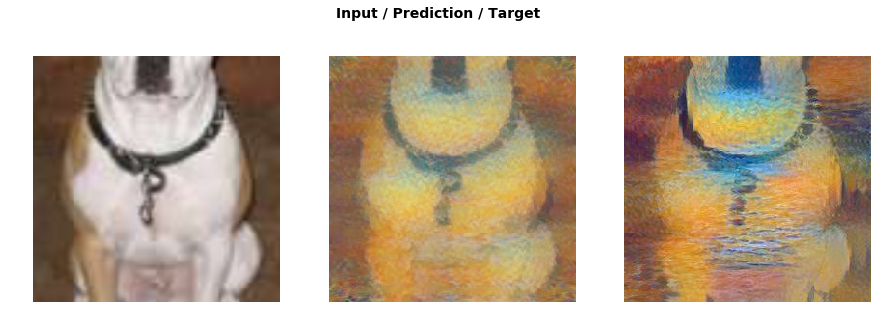

In [42]:
do_fit('2a')

In [43]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.633440,1.661697,0.338929,0.305611,0.264935,0.093316,0.240834,0.320091,0.097980
2,1.636672,1.662439,0.338239,0.305816,0.265915,0.093722,0.240812,0.319941,0.097994
3,1.630876,1.651365,0.336715,0.305728,0.264273,0.092895,0.236705,0.317287,0.097762
4,1.630698,1.652336,0.336751,0.305440,0.263674,0.092918,0.237603,0.318076,0.097874
5,1.628027,1.652598,0.335233,0.305314,0.264373,0.092932,0.238961,0.317897,0.097887
6,1.622456,1.652236,0.334720,0.305754,0.264049,0.092988,0.239227,0.317769,0.097728
7,1.614159,1.647799,0.333673,0.304889,0.264373,0.093023,0.237176,0.316962,0.097703
8,1.613826,1.650696,0.333413,0.305395,0.264024,0.092950,0.238165,0.318819,0.097930
9,1.616199,1.646712,0.332440,0.305456,0.264184,0.092992,0.237340,0.316643,0.097657
10,1.623145,1.649282,0.333545,0.305586,0.263895,0.092899,0.237928,0.317683,0.097746


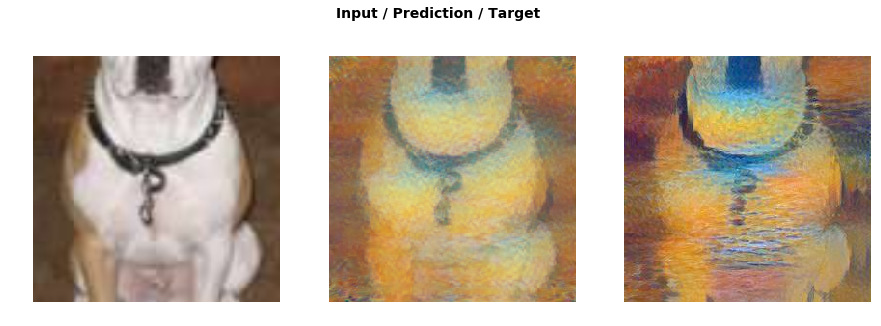

In [44]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [ ]:
learn = None
gc.collect();

In [ ]:
256/320*1024

In [ ]:
256/320*1600

In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(1280,1600), tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('2b');

In [ ]:
learn.data = data_mr

In [ ]:
fn = data_mr.valid_ds.x.items[0]; fn

In [ ]:
img = open_image(fn); img.shape

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
Image(img_hr).show(figsize=(18,15))